In [1]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

could not find pickled WD models
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
catalog = Table.read('data/01_catalog.fits')

In [3]:
i = 3
print(catalog['id'][i].split('_')[1].split('-'))

['51788', '0386', '0258*']


In [4]:
plate = []
mjd = []
fiber = []

for i in range(len(catalog)):
    try:
        mjd.append(int(catalog['id'][i].split('_')[1].split('-')[0]))
        plate.append(int(catalog['id'][i].split('_')[1].split('-')[1]))
        fiber.append(int(catalog['id'][i].split('_')[1].split('-')[2][:3]))
    except:
        print(i)
        a = int('342F#')
    


In [5]:
spec = []
wl = []
fl = []
ivar = []

for i in tqdm(range(len(catalog))):
    try:
        spec.append(SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits())
        
        wl.append(10**spec[i][1].data['loglam'])
        fl.append(spec[i][1].data['flux'])
        ivar.append(spec[i][1].data['ivar'])
    except:
        spec.append(-9999)
        wl.append(-9999)
        fl.append(-9999)
        ivar.append(-9999)
        
        
catalog['wd_spectrum'] = spec
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar
    
print(type(spec[0]))

  0%|                                                                                   | 0/101 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 130.68it/s]


<class 'astropy.io.fits.hdu.hdulist.HDUList'>


In [6]:
print(spec[0][1].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   32 / length of dimension 1                          NAXIS2  =                 3817 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    8 / number of table fields                         TTYPE1  = 'flux    '                                                            TFORM1  = 'E       '                                                            TTYPE2  = 'loglam  '                                                            TFORM2  = 'E       '                                                            TTYPE3  = 'ivar    '                    

In [14]:
def pseudonormalize(fl, win = 50):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl

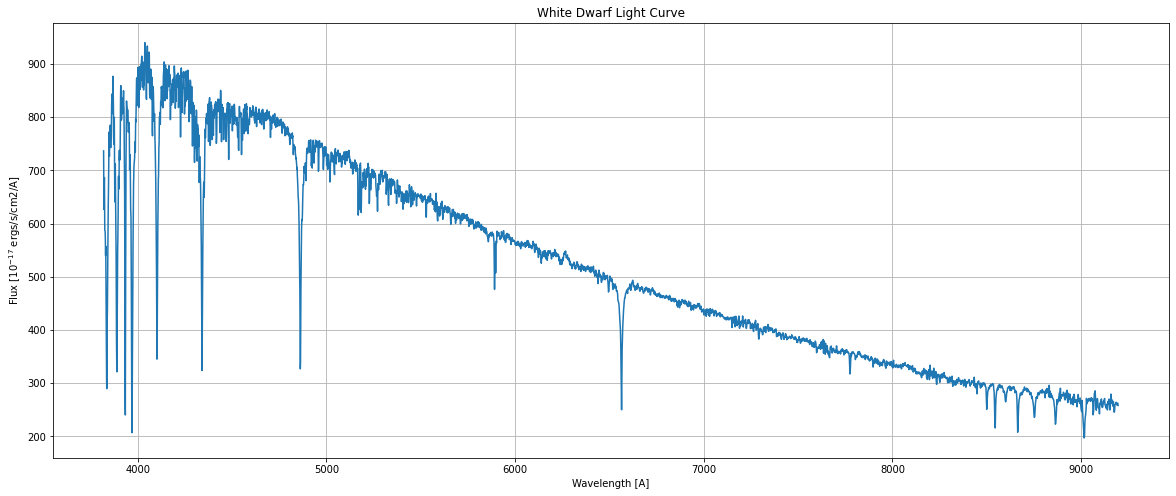

In [15]:
i = 0

plt.figure(figsize=(20,8))

plt.plot(wl[i], fl[i])
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Light Curve')
ax = plt.gca()

plt.show()

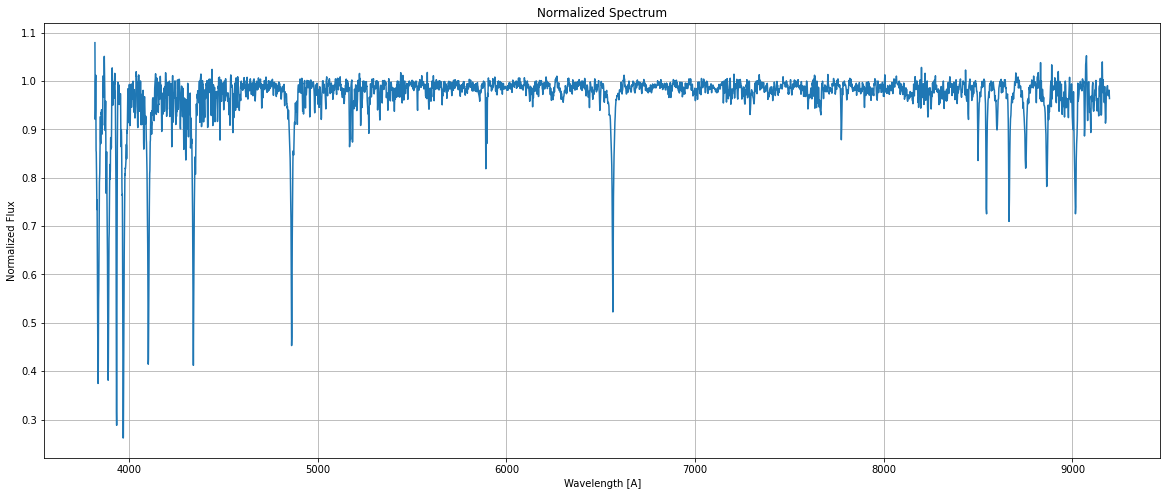

In [16]:
nwl = wl[i]
nfl = fl[i]
cont = pseudonormalize(nfl, 50)

plt.figure(figsize=(20,8))

plt.plot(nwl, cont)
plt.grid()
plt.ylabel(r'Normalized Flux')
plt.xlabel(r'Wavelength [A]')
plt.title('Normalized Spectrum')
ax = plt.gca()

plt.show()

In [10]:
corv_rv = []
val = []
stderr = []

corvmodel = corv.models.make_balmer_model()

for i in tqdm(range(len(catalog))):
    try:
        param_res, rv_res, rv_init = corv.fit.fit_corv(catalog['wd_wl'][i], catalog['wd_fl'][i], catalog['wd_ivar'][i], corvmodel)
        corv_rv.append(rv_res.params['RV'])
        val.append(rv_res.params['RV'].value)
        
        if rv_res.params['RV'].stderr is not None:
            stderr.append(rv_res.params['RV'].stderr)
        else:
            stderr.append(0)
    except:
        corv_rv.append(-9999)
        val.append(-9999)
        stderr.append(-9999)
        
catalog['wd_corv_rv'] = corv_rv
catalog['wd_corv_rv_val'] = val
catalog['wd_corv_rv_stderr'] = stderr

 30%|█████████████████████▉                                                    | 30/101 [00:28<00:08,  7.92it/s]KeyboardInterrupt

 39%|████████████████████████████▌                                             | 39/101 [00:29<00:07,  8.26it/s]KeyboardInterrupt
                                                     ^^^

 41%|██████████████████████████████                                            | 41/101 [00:29<00:07,  7.61it/s]KeyboardInterrupt
                    ^^^

 48%|███████████████████████████████████▏                                      | 48/101 [00:30<00:07,  6.77it/s]KeyboardInterrupt
                                                                                             ^^^

 65%|████████████████████████████████████████████████▎                         | 66/101 [00:35<00:15,  2.22it/s]KeyboardInterrupt
            ^^^

 82%|████████████████████████████████████████████████████████████▊             | 83/101 [00:38<00:01,  9.31it/s]KeyboardInterrupt
                     

In [11]:
print(catalog[['wd_corv_rv_val', 'wd_corv_rv_stderr']])
catalog = catalog[catalog['wd_corv_rv_stderr'] < 15]
print(len(catalog))

   wd_corv_rv_val   wd_corv_rv_stderr 
------------------- ------------------
 -39.09069589727915 2.6399686836422207
 -950.6504179419414 28.547025282231484
 -197.0795394764632 30.765473918928443
  580.5598328787328 174.94901677257542
-105.42195784783371  88.73555801289284
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
                ...                ...
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
            -9999.0            -9999.0
Length = 101 rows
97


In [11]:
print(catalog[['wd_corv_rv_val', 'wd_corv_rv_stderr']])


KeyboardInterrupt



In [ ]:
catalog.write('data/03_spectroscopy.fits')